In [ ]:
pip install opensoundscape

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 40.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.4/657.4 kB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.1/821.1 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 100.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.9/251.9 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━

In [ ]:
from opensoundscape.audio import Audio
from opensoundscape.spectrogram import Spectrogram
from opensoundscape.annotations import BoxedAnnotations
import os

import numpy as np
import pandas as pd

from glob import glob
from pathlib import Path

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for big visuals
%config InlineBackend.figure_format = 'retina'

<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
/usr/local/lib/python3.11/dist-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
input_dir = '/content/drive/MyDrive/Base de Datos Biofonica Lucas/Puerto Wilches/All - copia'  # Change to your directory path

# Collect all .wav and .mp3 files in the directory
audio_files = glob(os.path.join(input_dir, '*.wav')) + glob(os.path.join(input_dir, '*.mp3'))

In [ ]:
len(audio_files)

58

In [ ]:
# Directory to save spectrogram images
output_dir = 'spectrogram_images'
output_dir_ann = 'spectrogram_annotations'
os.makedirs(output_dir, exist_ok=True)
os.makedirs(output_dir_ann, exist_ok=True)

image_shape = (640, 640)

for audio_file in audio_files:
  # Path to your audio file
  audio_name = os.path.splitext(os.path.basename(audio_file))[0]
  if audio_file.endswith('.mp3'):
      annotation_file = audio_file.replace('.mp3', '.txt')
  elif audio_file.endswith('.wav'):
      annotation_file = audio_file.replace('.wav', '.txt')

  # Load the audio file
  audio = Audio.from_file(audio_file, sample_rate=44100)

  # Create an object from Raven file

  annot_list = [annotation_file]
  audio_list = [audio_file]

  annotations = BoxedAnnotations.from_raven_files(
      raven_files=annot_list,
      audio_files=audio_list,
      annotation_column="Event", # Put None if you don't have an annotation column
      keep_extra_columns=False
  )

  # Parameters
  clip_duration = 5  # seconds
  sr = 44100
  srhalf = int(sr/2)

  # Split the audio file into clips
  clips, clip_df = audio.split(clip_duration)

  # Generate and save spectrograms and YOLO format annotations
  for i, clip in enumerate(clips):
      # Convert the audio clip to a spectrogram object
      spec = Spectrogram.from_audio(clip, window_samples=1024)

      # Generate an image of the spectrogram
      #fig = spec.plot()

      # Save the figure
      image = spec.to_image(shape=image_shape, invert=True, channels=3, colormap='copper')
      image_path = os.path.join(output_dir, f'{audio_name}_{i}.png')
      image.save(image_path)

      # Find annotations within clip length
      annots = annotations.df[annotations.df['start_time'].between(i*5,(i + 1)*5)]
      yoloform = []
      for index, anot in annots.iterrows():
        if anot['end_time'] > (i + 1)*5:
          annots.at[index, 'end_time'] = (i + 1)*5

        if anot['end_time'] - anot['start_time'] < 0.3:
          continue

        anot['start_time'] = anot['start_time'] - (i*5)
        anot['end_time'] = anot['end_time'] - (i*5)

        yolox = ((anot['end_time'] + anot['start_time'])/2)/clip_duration
        yoloy = 1 - ((anot['high_f'] + anot['low_f'])/2)/srhalf
        yolow = ((anot['end_time'] - anot['start_time']))/clip_duration
        yoloh = ((anot['high_f'] - anot['low_f']))/srhalf

        yoloform.append(f'0 {yolox} {yoloy} {yolow} {yoloh}')

      txt_path = os.path.join(output_dir_ann, f'{audio_name}_{i}.txt')
      with open(txt_path, 'w') as f:
          f.write('\n'.join(yoloform))

    # Close the figure to free up memory
    #plt.close(fig)

<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()


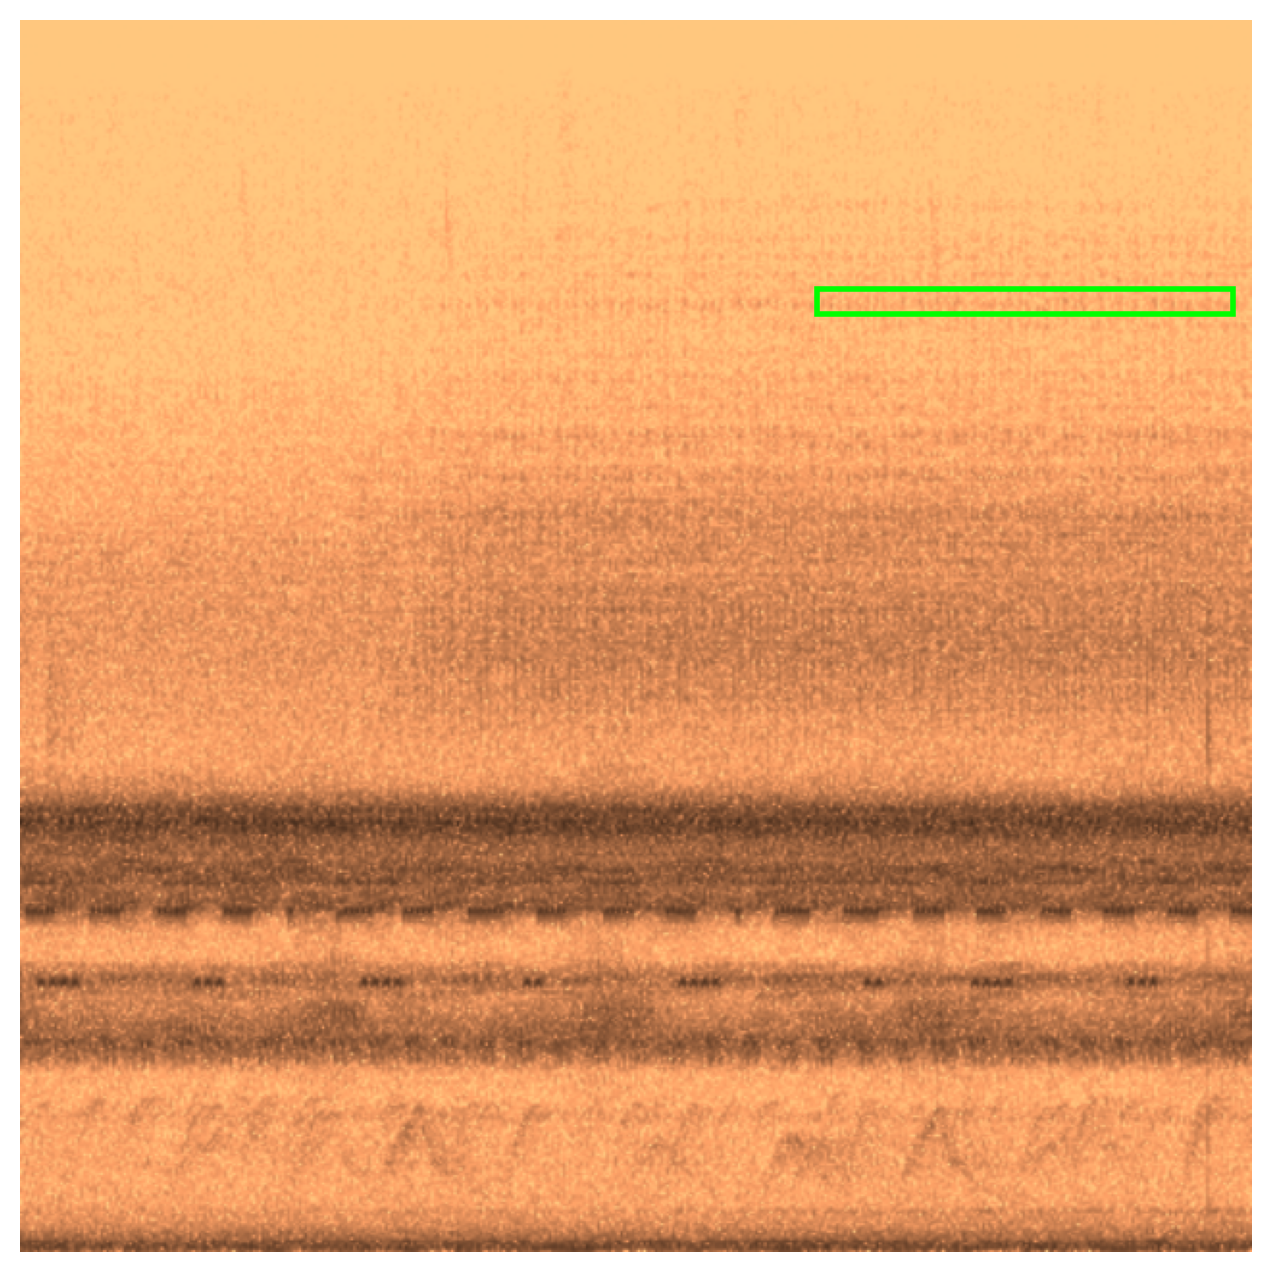

<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()


In [ ]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_yolo_boxes_matplotlib(image_path, annotation_path, class_names=None):
    # Load the image in RGB for Matplotlib
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    height, width, _ = image.shape

    # Create plot
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)

    # Read YOLO annotation file
    with open(annotation_path, 'r') as file:
        lines = file.readlines()

    # Plot each bounding box
    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        x_center, y_center, w, h = map(float, parts[1:])

        # Convert normalized coordinates to pixel values
        x_center *= width
        y_center *= height
        w *= width
        h *= height

        # Calculate top-left corner
        x1 = x_center - w / 2
        y1 = y_center - h / 2

        # Create a rectangle patch
        rect = patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)

        # Add class label text
        #label = f"{class_names[class_id]}" if class_names else f"Class {class_id}"
        #ax.text(x1, y1 - 5, label, color='lime', fontsize=12, backgroundcolor="black")

    ax.axis('off')
    plt.show()

# Example usage
image_path = "/content/spectrogram_images/SMA03126_20210323_195000_0.png"
annotation_path = "/content/spectrogram_annotations/SMA03126_20210323_195000_0.txt"

draw_yolo_boxes_matplotlib(image_path, annotation_path)

In [ ]:
!zip -r /content/spectrogram_images.zip /content/spectrogram_images
!zip -r /content/spectrogram_annotations.zip /content/spectrogram_annotations

  adding: content/spectrogram_images/ (stored 0%)
  adding: content/spectrogram_images/SMA03126_20210323_195000_11.png (deflated 0%)
  adding: content/spectrogram_images/SMA03126_20210323_195000_3.png (deflated 0%)
  adding: content/spectrogram_images/SMA03251_20210326_200000_6.png (deflated 0%)
  adding: content/spectrogram_images/SMA03126_20210609_163000_6.png (deflated 0%)
  adding: content/spectrogram_images/SMA03210_20210608_055000_6.png (deflated 0%)
  adding: content/spectrogram_images/SMA03294_20210603_193000_5.png (deflated 0%)
  adding: content/spectrogram_images/SMA03247_20210606_200000_5.png (deflated 0%)
  adding: content/spectrogram_images/SMA03320_20210327_195000_1.png (deflated 0%)
  adding: content/spectrogram_images/SMA03251_20210605_053000_10.png (deflated 0%)
  adding: content/spectrogram_images/SMA03320_20210319_171000_5.png (deflated 0%)
  adding: content/spectrogram_images/SMA03175ICP_20210326_180000_1.png (deflated 0%)
  adding: content/spectrogram_images/SMA033